In [1]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt

In [2]:
def mgrid(len, dim = 2):
    t = []
    for i in range(dim):
        lin = tf.linspace(-1, 1, len)
        t.append(lin)
    mesh = tf.meshgrid(*t, indexing = "ij")
    mgrid = tf.stack(mesh, axis = -1)
    mgrid = tf.reshape(mgrid, [-1,dim])
    return mgrid

In [3]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, is_first = False, omega_0 = 30, use_bias = True, **kwargs):
        super(SineLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.is_first = is_first
        self.omega_0 = omega_0
        self.use_bias = use_bias
        
    def build(self, input_shape):
        if self.is_first:
            limit = 1/self.in_features
        else:
            limit = np.sqrt(6/self.in_features)/self.omega_0
        self.w = self.add_weight(shape = (self.in_features, self.out_features), initializer = tf.keras.initializers.RandomUniform(minval = -limit, maxval = limit), trainable = True, name = 'weights')
        if self.use_bias:
            self.b = self.add_weight(shape = (self.out_features, ), initializer = tf.keras.initializers.Zeros(), trainable = True, name = 'bias')
        else:
            self.b = None
            
    def call(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        if self.b is not None:
            x += self.b
        return tf.sin(self.omega_0 * x)
        
    def call_with_intermediate(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        if self.b is not None:
            x += self.b
        intermediate = self.omega_0 * x
        return tf.sin(intermediate), intermediate

In [7]:
class FinerLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, is_first = False, omega_0 = 2.5, k = 10, **kwargs):
        super(FinerLayer, self).__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.is_first = is_first
        self.omega_0 = omega_0
        self.k = k
    def build(self, input_shape):
        if self.is_first:
            limit = 1/self.in_features
        else:
            limit = np.sqrt(6/self.in_features)/self.omega_0
        self.w = self.add_weight(shape = (self.in_features, self.out_features), initializer = tf.keras.initializers.RandomUniform(minval = -limit, maxval = limit), trainable = True, name = 'weights')
        self.b = self.add_weight(shape = (self.out_features, ), initializer = tf.keras.initializers.RandomUniform(minval = -self.k, maxval = self.k), trainable = True, name = 'bias')
    def call(self, inputs):
        x = tf.linalg.matmul(inputs, self.w)
        x += self.b
        modulated = (tf.abs(x) + 1) * x
        a = tf.sin(self.omega_0 * modulated)
        return a


In [9]:
def SirenModel(input_f, output_f, hidden_features, hidden_layers, outermost_linear = False, first_omega = 20, hidden_omega = 30):
    input_img = tf.keras.Input(shape = (input_f,))
    x = SineLayer(in_features = input_f, out_features = hidden_features, is_first = True, omega_0 = first_omega, use_bias = True)(input_img)
    for i in range(hidden_layers):
        x = SineLayer(in_features = hidden_features, out_features = hidden_features, is_first = False, omega_0 = hidden_omega, use_bias = True)(x)
    if outermost_linear:
        output = tf.keras.layers.Dense(output_f, activation = 'tanh', kernel_initializer = tf.keras.initializers.RandomUniform(minval = -np.sqrt(6/hidden_features)/hidden_omega, maxval = np.sqrt(6/hidden_features)/hidden_omega))(x)
    else:
        output = SineLayer(in_features = hidden_features, out_features = output_f, is_first = False, omega_0 = hidden_omega, use_bias = True)(x)
    model = tf.keras.Model(inputs = input_img, outputs = output)
    return model


In [11]:
def FinerModel(in_f, out_features, hidden_features, hidden_layers, omega_0 = 2.50, hidden_omega_0 = 2.50, k= 10, outermost_linear = False):
    Input_img = tf.keras.Input(shape =(in_f, ))
    x = FinerLayer(in_features = in_f, out_features = hidden_features,is_first = True, omega_0 = omega_0, k = k)(Input_img)
    for i in range(hidden_layers):
        x = FinerLayer(hidden_features, hidden_features, hidden_omega_0, k = k)(x)
    if outermost_linear:
        output = tf.keras.layers.Dense(out_features, activation = 'tanh', kernel_initializer =  tf.keras.initializers.RandomUniform(minval = -np.sqrt(6/hidden_features)/hidden_omega_0, maxval = np.sqrt(6/hidden_features)/hidden_omega_0))(x)
    else:
        output = FinerLayer(in_features = hidden_features, out_features = out_features, omega_0 = hidden_omega_0, k = k)(x)
    model = tf.keras.Model(inputs = Input_img, outputs = output)
    return model

In [75]:
siren_model = SirenModel(input_f =2, output_f = 3, hidden_features = 256, hidden_layers = 5, outermost_linear = True, first_omega = 30, hidden_omega = 30)
siren_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_18 (SineLayer)       │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_19 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_20 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_21 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_22 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sine_layer_23 (SineLayer)       │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,499 (1.26 MB)

 Trainable params: 330,499 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
finer_model = FinerModel(in_f = 2, out_features =3, hidden_features = 256, hidden_layers = 5, omega_0 = 2.5, hidden_omega_0 = 2.50,k = 10, outermost_linear = True)
finer_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_12 (FinerLayer)     │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_13 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_14 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_15 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_16 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ finer_layer_17 (FinerLayer)     │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 330,499 (1.26 MB)

 Trainable params: 330,499 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import os 
from PIL import Image 
def bsds_tensor(sidelength, split = 'test', id = '101085', bsds_dir = "C:/Users/HP/Downloads/summer project/archive (1)/BSDS300/BSDS300/images"):
    filepath = os.path.join(bsds_dir, split, f'{id}.jpg')
    img = Image.open(filepath).convert('RGB')
    img = tf.convert_to_tensor(np.array(img)/255, dtype = tf.float32)
    #img_new = tf.image.resize(img, size=(sidelength,sidelength), method="bicubic").numpy()
    height, width = tf.shape(img)[0], tf.shape(img)[1]
    crop_x = (height - sidelength) // 2
    crop_y = (width - sidelength) // 2
    img_cropped = img[crop_x:crop_x+sidelength, crop_y:crop_y+sidelength, :]
    return img_cropped

(256, 256, 3)


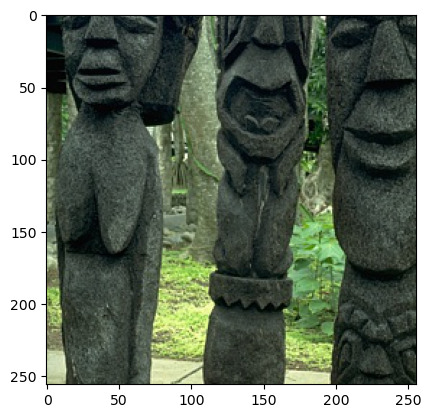

In [23]:
img = bsds_tensor(256, split = 'test', id = '101085')
print(img.shape)
fig = plt.figure()
plt.imshow(img)

In [25]:
def noisy_image(img, sigma):
    noise = tf.random.normal(shape = tf.shape(img), mean = 0, stddev = sigma, dtype = img.dtype)
    img_noisy = tf.clip_by_value(img + noise, clip_value_min = 0, clip_value_max = 1)
    return tf.cast(img_noisy, tf.float32)

(256, 256, 3)


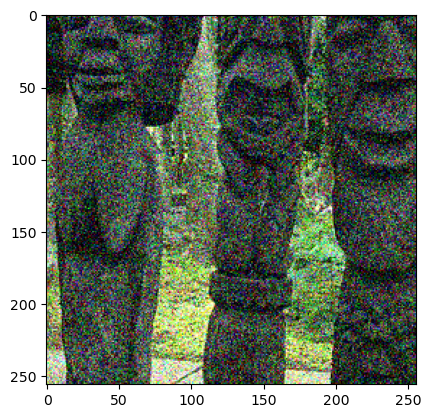

In [27]:
ni = noisy_image(img, 0.2)
print(ni.shape)
fig = plt.figure()
plt.imshow(ni)

In [29]:
class ImageFitting(tf.data.Dataset):
    def __new__(cls, sidelength, split = 'test', id = '101085', sigma = 0.1, bsds_dir = "C:/Users/HP/Downloads/summer project/archive (1)/BSDS300/BSDS300/images"):
        clean_img = bsds_tensor(sidelength, split, id, bsds_dir)
        img_noise = noisy_image(clean_img, sigma)
        coords = mgrid(sidelength)
        pixels = tf.reshape(img_noise, [-1,3])
        dataset = tf.data.Dataset.from_tensor_slices((coords, pixels))
        dataset = dataset.batch(sidelength * sidelength, drop_remainder = True)
        return dataset, clean_img

In [31]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
def training_model(sidelength, model, s = 'test', id = '101085', sigma = 0.1, total_steps = 600):
    dataloader, img_clean = ImageFitting(sidelength, s, id, sigma)
    img_clean = np.array(img_clean, dtype=np.float32)
    img_clean = (img_clean - img_clean.min())/(img_clean.max() - img_clean.min())
    model_input, ground_truth = next(iter(dataloader))
    img_in = tf.reshape(ground_truth, (sidelength,sidelength,3)).numpy()
    
    optimizer = tf.keras.optimizers.Adam(1e-4)
    
    psnr_cleans = []
    best_psnr_clean, best_step = -np.inf, 0
    
    for step in range(total_steps + 1):
        with tf.GradientTape() as tape:
            model_output = model(model_input, trainig = True)
            loss = tf.reduce_mean((model_output - ground_truth) ** 2)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        img_out = np.array(tf.reshape(model_output, (sidelength, sidelength, 3)).numpy(), dtype=np.float32)
        psnr = compare_psnr(img_clean, img_out)
        psnr_cleans.append(psnr)
        if psnr>best_psnr_clean:
            best_psnr_clean = psnr
            best_step = step
        if step % 20 == 0:
            print(f"step {step}, loss:{loss.numpy():.6f}, psnr_clean:{psnr:.2f}")
    
    img_out_scaled = (img_out - img_out.min()) / (img_out.max() - img_out.min())
    img_in_scaled = (img_in - img_in.min())/(img_in.max() - img_in.min())
    fig,axs = plt.subplots(1,3, figsize = (15,5))
    axs[0].imshow(img_out_scaled); axs[0].set_title("Model Output")
    axs[1].imshow(img_in_scaled); axs[1].set_title("Noisy Input")
    axs[2].imshow(img_clean); axs[2].set_title("Clean Image")
    plt.show()
    return psnr_cleans, img_out_scaled



step 0, loss:0.232309, psnr_clean:6.64
step 20, loss:0.035262, psnr_clean:15.45
step 40, loss:0.021989, psnr_clean:18.49
step 60, loss:0.017884, psnr_clean:19.97
step 80, loss:0.015588, psnr_clean:21.04
step 100, loss:0.013990, psnr_clean:21.91
step 120, loss:0.012768, psnr_clean:22.64
step 140, loss:0.011747, psnr_clean:23.29
step 160, loss:0.010873, psnr_clean:23.85
step 180, loss:0.010102, psnr_clean:24.32
step 200, loss:0.009387, psnr_clean:24.71
step 220, loss:0.008710, psnr_clean:24.98
step 240, loss:0.008077, psnr_clean:25.10
step 260, loss:0.007470, psnr_clean:25.09
step 280, loss:0.006897, psnr_clean:24.97
step 300, loss:0.006238, psnr_clean:24.71


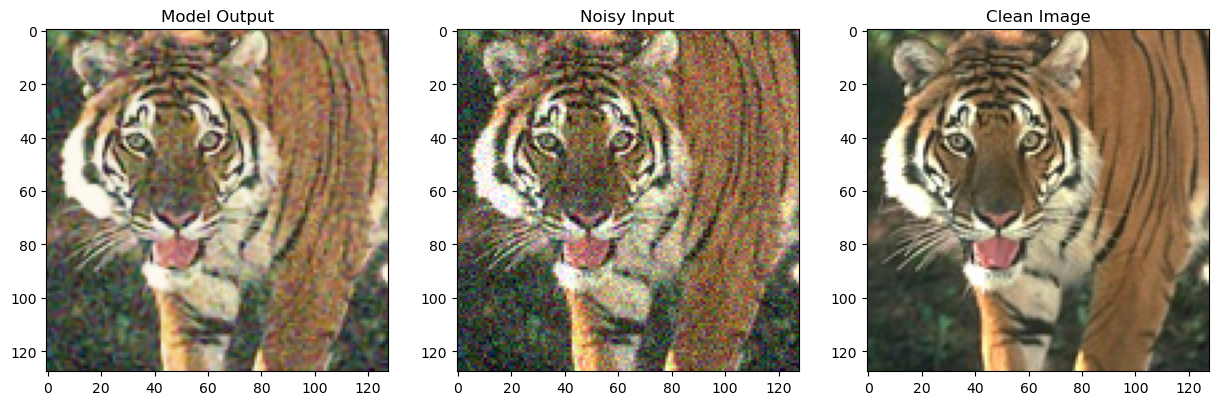

In [79]:
psnr1, image_output = training_model(sidelength = 128, model = siren_model, sigma =0.1, total_steps = 300)

In [81]:
image = bsds_tensor(sidelength = 128, split = 'test', id = '101085')
image = image.numpy()
image_output1 = image_output.astype(np.float32)
#ssim_value = ssim(image, image_output, data_range = 1, win_size = 3)
print("PSNR for siren model denoising:", psnr1[-1])
#print("SSIM:", ssim_value)

PSNR for siren model denoising: 24.70908958360102


step 0, loss:0.413647, psnr_clean:4.04
step 20, loss:0.037927, psnr_clean:15.43
step 40, loss:0.021093, psnr_clean:18.83
step 60, loss:0.017343, psnr_clean:20.20
step 80, loss:0.015632, psnr_clean:21.02
step 100, loss:0.014375, psnr_clean:21.70
step 120, loss:0.013318, psnr_clean:22.32
step 140, loss:0.012410, psnr_clean:22.89
step 160, loss:0.011648, psnr_clean:23.41
step 180, loss:0.011020, psnr_clean:23.83
step 200, loss:0.013052, psnr_clean:22.51
step 220, loss:0.010582, psnr_clean:23.77
step 240, loss:0.009882, psnr_clean:24.40


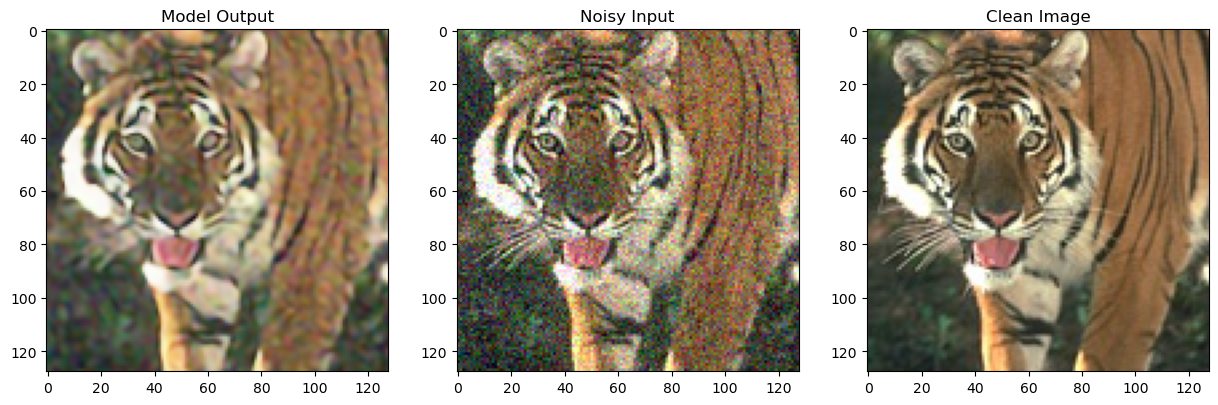

In [83]:
psnr3, image_output3 = training_model(sidelength = 128, model = finer_model, sigma =0.1, total_steps = 250)

In [85]:
image = bsds_tensor(sidelength = 128, split = 'test', id = '101085')
image = image.numpy()
image_output3 = image_output.astype(np.float32)
#ssim_value = ssim(image, image_output3, data_range = 1, win_size = 3)
print("PSNR for finer model denoising:", psnr3[-1])
#print("SSIM:", ssim_value)

PSNR for finer model denoising: 24.630872817100208
